# Modeling lensing ratios

Cluster finders such as redMaPPer impart a selection function on the halos in their catalogs. We would like to think that this selection function is a nice power law between the observable and the mass -- and it might be. Unfortunately, selection functions oftentimes have unintended consequences on observables measured on the clusters in the catalogs, such as stacked gravitational weak lensing profiles. The cluster selection can create or exacerbate existing systematics that affect the lensing profiles.

In this notebook we will take some measured lensing profiles from simulations on cluster stacks created by redMaPPer, and similar stacks but with all selection effects eliminated (a so-called "same-mass" selection).

## Stacked lensing

Stacked cluster weak lensing is a measurements of the ensemble average (over the catalog) of the weak lensing signal measured around a selection of galaxy clusters. The lensing is written in terms of the differential surface mass density profile $\Delta\Sigma$ which is defined as
$$
\Delta\Sigma(R) = \Sigma(<R) - \Sigma(R)\,,
$$
where $\Sigma(R)$ is the (ensemble average) surface mass density at radius $R$, and $\Sigma(<R)$ is the average surface mass density over the disk interior to $R$.

Our goal will be to find a model to modify the theory curves for $\Sigma(R)$ and recover $\Sigma(R)$ that has selection effects. This will be used later as a template to modify our lensing models and obtain accurate cluster masses.


## redMaPPer selected vs same-mass selected

Heidi Wu (OSU) has measured stacked surface mass density profiles $\Sigma(R)$ for stacks of redMaPPer selected clusters in the Buzzard simulations in bins of redshift and richness. Since this is in simulations, we know the masses of the halos in which the clusters reside. Heidi made another stack of halos randomly selected until the selection matched the masses of the original stack. Selected in this way, the second stack has no systematics on the surface mass density profile imparted by the redMaPPer selection. Therefore, the ratio of the two profiles encodes the effect of the selection function, and is the quantity we want to model.

In other words, we will be building a model for the function
$$
\mathcal{F}(R|\lambda,z) = \frac{\Sigma(R|\mathrm{redMaPPer})}{\Sigma(R|\mathrm{same-mass})}\,.
$$
We also have uncertainties measured for the two $\Sigma(R)$ profiles, which we will call $\sigma_{RM}$ and $\sigma_{SM}$ for the redMaPPer and same-mass measurements, respectively. Propogating the uncertainties, we see that the variance on $\mathcal{F}$ is
$$
\sigma_{\mathcal{F}}^2 = \frac{\sigma_{RM}^2}{\Sigma_{SM}^2} + \sigma_{SM}^2\frac{\Sigma_{RM}^2}{\Sigma_{SM}^4}\,.
$$

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rc("font", size=24, family="serif")
plt.rc("text", usetex=True)
plt.rc("errorbar", capsize=2)

In [3]:
#Prepare loading the data and figure titles
zs = ["0.2_0.35", "0.35_0.5", "0.5_0.65"]
lams = ["20_30", "30_45", "45_60", "60_10000"]
z_titles = ["0.2,0.35", "0.35,0.5" ,"0.5, 0.65"]
lam_titles = ["20,30", "30,45", "45,60", "60,\infty"]
rm_path = "Sigma_for_TomM/Sigma_z_{0}_lam_{1}.dat"
sm_path = "Sigma_for_TomM/Sigma_same_mass_redshift_distribution_z_{0}_lam_{1}.dat"
names =["R", "Sigma", "err"]

In [4]:
#Plot a lensing ratio
def get_data_frame(zi, lj):
    """Returns the lensing ratio for the zi-th redshift bin
    and lj-th lambda bin.
    """
    df1 = pd.read_csv(rm_path.format(zs[zi], lams[lj]), sep=' ', header=None, skiprows=1)
    df1.drop(3, axis=1, inplace=True)
    df1.columns = names
    df2 = pd.read_csv(sm_path.format(zs[zi], lams[lj]), sep=' ', header=None, skiprows=1)
    df2.drop(3, axis=1, inplace=True)
    df2.columns = names
    df1 = df1.merge(df2, how="left", on="R", suffixes=("", "SM"))
    
    df1["lnR"] = np.log10(df1.R)
    df1["F"] = df1.Sigma / df2.Sigma
    df1["Ferr"] = np.sqrt(df1.err**2 / df2.Sigma**2 + df2.err**2 * df1.Sigma**2 / df2.Sigma**4)
    return df1

,R,Sigma,err,SigmaSM,errSM,lnR,F,Ferr
0,0.040563,679.745,17.56660,622.276,10.14480,-1.391867,1.092353,0.033377
1,0.063973,531.199,13.29760,484.610,7.79132,-1.194005,1.096137,0.032612
2,0.100892,380.631,9.29573,345.530,5.57827,-0.996143,1.101586,0.032250
3,0.159117,260.482,6.23750,233.743,3.83592,-0.798283,1.114395,0.032351
4,0.250945,171.579,4.01676,152.026,2.54508,-0.600421,1.128616,0.032482


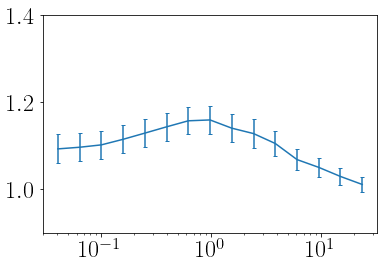

In [5]:
df = get_data_frame(0, 0)
plt.errorbar(df.R, df.F, df.Ferr)
#plt.xlim(.1, 20)
plt.ylim(0.9, 1.4)
plt.xscale("log")
df.head()

## Modeling the ratio

We are going to try to model this ratio. For now, we will attempt to model this as some kind of polynomial in $\ln R$
$$
\mathcal{F}(R) = \sum_{i=0}^M a_i (\ln R)^i\,.
$$
After that we will explore forcing this to asymptote to 1 at large $R$, and to a constant at small $R$. In fact, to facilitate this we will will set $a_0=1$ (i.e. fit the fluctuation above $\mathcal{F} = 1$), and also change the independent variable to $x = \ln (R/30)$, so that we force $\mathcal{F}(R=30) = 1$.

We will solve for these slopes using least squares (a.k.a. $\chi^2$ minimization). Since we have errorbars (a diagonal covariance matrix), we know that 
$$
\chi^2 = (F - XA)^TC^{-1}(F - XA)\,,
$$
where $C$ is our covariance matrix, $F$ is an $N$-length vector containing the ratios, $X$ is an $M\times N$ matrix containing powers of the radii (including a column of ones), and $A$ is a vector of our linear parameters. Taking the derivative of this equation with respect to $A$ and setting it to zero gives us 
$$
A = (X^TC^{-1}X)^{-1}X^TC^{-1}F\,.
$$

We will also write this so that we can actually pick arbitrary powers, not just all powers from $1,...,M$.

In [6]:
#We should probably objectify this whole thing
class PolyModel(object):
    def __init__(self, zi, lj, powers):
        df = get_data_frame(zi, lj)
        df["Fp"] = df.F - 1
        x = np.log10(df.R/30.) #df.lnR
        M = len(powers)
        X = np.ones((len(x), M))
        for i in range(0, M):
            X[:, i] = x**powers[i]

        C = np.diag(df.Ferr**2)
        Ci = np.linalg.inv(C) #I shouldn't do this...
        XCX = X.T @ Ci @ X
        self.Acov = np.linalg.inv(XCX)
        self.Avars = np.diag(self.Acov) #Variances of the parameters
        self.A = self.Acov @ X.T @ Ci @ df.Fp
        self.Fmodel = X @ self.A + 1
        self.df = df
        self.M = M
        self.powers = powers
        self.chi2 = (df.F - self.Fmodel).T @ Ci @ (df.F - self.Fmodel)
        self.BIC = np.log(len(x))*M - 2*ss.multivariate_normal.logpdf(df.F, mean=self.Fmodel, cov=C)
        
    def get_N_free_params(self):
        return self.M
        
    def get_DoF(self):
        return len(self.df.lnR) - self.M
    
    def get_data(self):
        return self.df.R, self.df.F, self.df.Ferr
    
    def get_model(self):
        return self.Fmodel
    
    def get_chi2(self):
        return self.chi2
    
    def get_BIC(self):
        return self.BIC

DoF  = 12.00
chi2 = 2.78
BIC  = -53.72


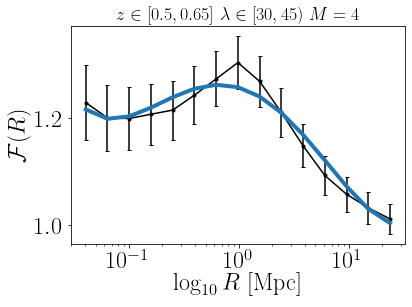

In [7]:
zi = 2
lj = 1
powers = [2,3,4]
model00 = PolyModel(zi, lj, powers)

R, F, Ferr = model00.get_data()
Fmodel = model00.get_model()
plt.errorbar(R, F, Ferr, c='k', marker='.')
plt.xscale("log")
plt.plot(R, Fmodel, zorder=10, lw=4)
plt.xlabel(r"$\log_{10} R\ [{\rm Mpc}]$")
plt.ylabel(r"$\mathcal{F}(R)$")
plt.title(r"$z\in[{0}]\ \lambda\in[{1})\ M={2:d}$".format(z_titles[zi], lam_titles[lj], max(model00.powers)), 
          fontsize=18)

print("DoF  = {0:.2f}".format(model00.get_DoF()))
print("chi2 = {0:.2f}".format(model00.get_chi2()))
print("BIC  = {0:.2f}".format(model00.get_BIC()))

## Power law model

It looks like our power law model is doing well. The example plotted above is working fine with a model that goes up to $x^4$. Let's make a multipanel plot showing these for all bins.

In [25]:
models = [] #Will hold a 2D list of model objects
powers = [2,3,4] #Degree of model we will use
for zi in range(3):
    modelsi = []
    for lj in range(4):
        modelsi.append(PolyModel(zi, lj, powers))
    models.append(modelsi)

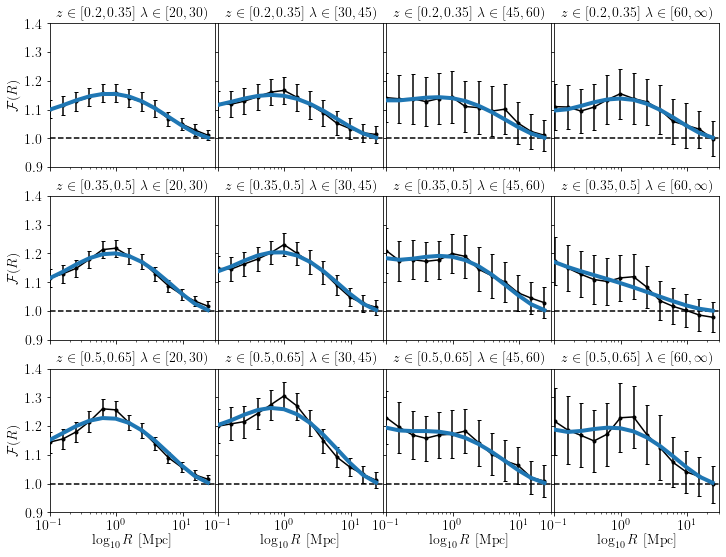

In [26]:
plt.rc("font", size=14)
fig, axes = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, figsize=(12, 9))
plt.subplots_adjust(wspace = 0.02, hspace = 0.2)

for zi in range(3):
    for lj in range(4):
        ax = axes[zi, lj]
        R, F, Ferr = models[zi][lj].get_data()
        Fmodel = models[zi][lj].get_model()
        ax.errorbar(R, F, Ferr, c='k', marker='.')
        ax.plot(R, Fmodel, zorder=10, lw=4)
        ax.axhline(1, c='k', ls='--')
        ax.set_title(r"$z\in[{0}]\ \lambda\in[{1})$".format(z_titles[zi], lam_titles[lj]), 
                               fontsize=14)
        if zi == 2:
            ax.set_xlabel(r"$\log_{10} R\ [{\rm Mpc}]$")
        if lj == 0:
            ax.set_ylabel(r"$\mathcal{F}(R)$")
axes[0,0].set_xlim(.1, 30)
axes[0,0].set_ylim(.9, 1.4)
axes[0,0].set_xscale("log")
#fig.savefig("model_fits.png", dpi=300, bbox_inches="tight")

## Trends of the fitting parameters

Let's take a look at the trends of these parameters with richness and redshift, $a_i(\lambda, z)$.

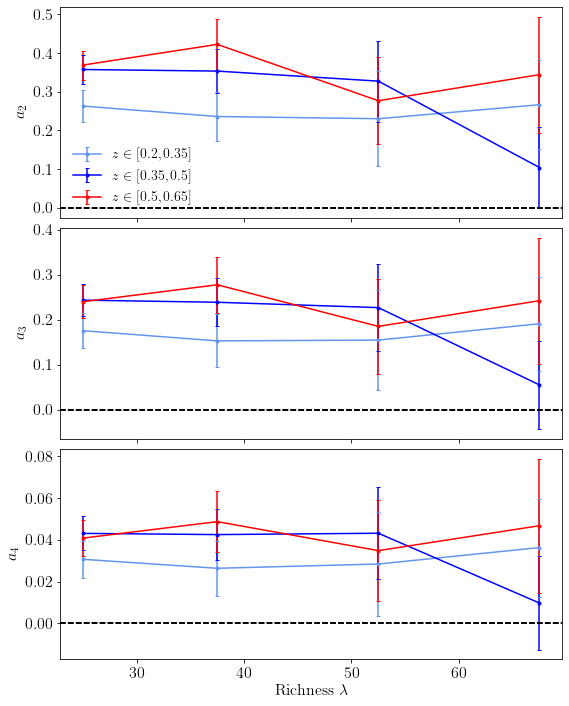

In [27]:
plt.rc("font", size=16)
colors = ["cornflowerblue", "blue", "red"]
label = r"$z\in[{0}]$"
richnesses = np.array([25, 37.5, 52.5, 67.5]) #richnesses
fig, axes = plt.subplots(ncols=1, nrows=len(powers), sharex=True, figsize=(9, 12))
plt.subplots_adjust(hspace=0.05)

for i in range(len(powers)):
    for zi in range(3):
        azi = np.zeros(4) #a_i for each lambda bin at this redshift
        azi_unc = np.zeros_like(azi) #errorbar on each a_i
        for lj in range(4):
            azi[lj] = models[zi][lj].A[i]
            azi_unc[lj] = np.sqrt(models[zi][lj].Avars[i])
        if i == 0:
            axes[i].errorbar(richnesses, azi, azi_unc, color=colors[zi], marker='.', 
                             label = label.format(z_titles[zi]))
        else:
            axes[i].errorbar(richnesses, azi, azi_unc, color=colors[zi], marker='.')
        axes[i].axhline(0, c="k", ls="--")
    axes[i].set_ylabel(r"$a_{0:d}$".format(powers[i]))
axes[0].legend(loc = "lower left", frameon=False, fontsize=14)
axes[len(powers)-1].set_xlabel(r"Richness $\lambda$");
fig.savefig("param_trends.png", dpi=300, bbox_inches="tight")

[[1.         0.98431621 0.9539502 ]
 [0.98431621 1.         0.99148688]
 [0.9539502  0.99148688 1.        ]]


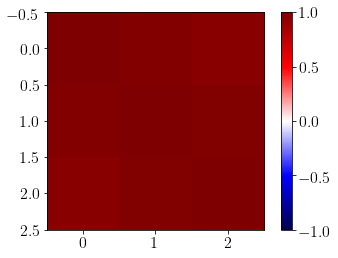

In [28]:
cov = models[0][0].Acov
Diag = np.linalg.inv(np.diag(np.sqrt(cov.diagonal())))
corr = Diag @ cov @ Diag
plt.imshow(corr, vmin=-1, vmax=1, cmap="seismic")
plt.colorbar()
print(corr)

## Modeling across bins

We can draw some conclusions from the above plots:
1. The fit parameters seem to be roughly constant with richness
2. there may be a reshift trend.

Therefore, we are motivated to add a slight amount of complexity to the model that will hopefully result in a reduction of the number of parameters down from $M\times N_{\rm bins}$ to just $M\times 2$ parameters. I propose to use a model for the parameters that is linear in redshift and constant in richness:
$$
a_i(z,\lambda) = a_i(z) = a_i^0 + (z-0.4)a_i^1\,,
$$
where $a_i^0$ and $a_i^1$ are the intercept and slopes of this relation, respectively.